## This is the general EDA notebook

In [12]:
# typical imports
import pandas as pd
import numpy as np
import matplotlib

import random 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

%matplotlib inline

/Users/zgreyn/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

/Users/zgreyn/.local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.



In [157]:
pbp2015 = pd.read_csv('../data/pbp-2015.csv')
#pbp2014 = pd.read_csv('../data/pbp-2014.csv')
#pbp2013 = pd.read_csv('../data/pbp-2013.csv')

- Check descriptions for NaN formations --> They were timeouts or 2-min warnings
* We could bin up ToGo 1, 2-5, 6-10, 10-15, 15+
- Combine No Huddle with corresponding formations --> There's a straight 'NO HUDDLE' formation, so nothing would be left
- Combine IsRush/IsPass with other outcomes (punt, field goal, etc.) and make that the target
* Train GBC on it
* Bayesian classifier?

## EDA and Cleaning

In [99]:
for column in pbp2015:
    print column, pbp2015[column].unique()

GameId [2015091000 2015091300 2015091301 2015091302 2015091303 2015091304
 2015091305 2015091306 2015091307 2015091308 2015091309 2015091310
 2015091311 2015091312 2015091400 2015091401 2015091700 2015092000
 2015092001 2015092002 2015092003 2015092004 2015092005 2015092006
 2015092007 2015092008 2015092009 2015092010 2015092011 2015092012
 2015092013 2015092100 2015092400 2015092700 2015092701 2015092702
 2015092703 2015092704 2015092705 2015092706 2015092707 2015092708
 2015092709 2015092710 2015092711 2015092712 2015092713 2015092800
 2015100100 2015100400 2015100401 2015100402 2015100403 2015100404
 2015100405 2015100406 2015100407 2015100408 2015100409 2015100410
 2015100411 2015100412 2015100500 2015100800 2015101100 2015101101
 2015101102 2015101103 2015101104 2015101105 2015101106 2015101107
 2015101108 2015101109 2015101110 2015101111 2015101200 2015101500
 2015101800 2015101801 2015101802 2015101803 2015101804 2015101805
 2015101806 2015101807 2015101808 2015101809 2015101810

In [100]:
# drop all columns with no info
pbp2015.drop(['Unnamed: 10', 'Unnamed: 12','Unnamed: 16', 'Unnamed: 17', 'Challenger'], axis=1, inplace=True)
pbp2015.drop(['IsMeasurement', 'NextScore', 'TeamWin'], axis=1, inplace=True)

In [101]:
# drop all columns we won't use
pbp2015.drop(['IsIncomplete', 'IsTouchdown','IsSack', 'IsChallenge', 'IsChallengeReversed'], axis=1, inplace=True)
pbp2015.drop(['IsInterception', 'IsPenalty', 'IsTwoPointConversion', 'SeriesFirstDown'], axis=1, inplace=True)
pbp2015.drop(['IsTwoPointConversionSuccessful', 'IsPenaltyAccepted', 'PenaltyTeam'], axis=1, inplace=True)
pbp2015.drop(['IsFumble', 'PenaltyType', 'PenaltyYards', 'SeasonYear', 'GameId', 'GameDate'], axis=1, inplace=True)
pbp2015.drop(['IsNoPlay'], axis=1, inplace=True)

In [102]:
pbp2015.PlayType.unique()

array([nan, 'RUSH', 'PASS', 'TIMEOUT', 'PUNT', 'QB KNEEL', 'KICK OFF',
       'NO PLAY', 'SCRAMBLE', 'FIELD GOAL', 'SACK', 'EXTRA POINT',
       'TWO-POINT CONVERSION', 'EXCEPTION', 'FUMBLES', 'CLOCK STOP',
       'PENALTY'], dtype=object)

In [103]:
pbp2015.PassType.unique()

array([nan, 'DEEP MIDDLE', 'SHORT LEFT', 'SHORT RIGHT', 'SHORT MIDDLE',
       'DEEP LEFT', 'DEEP RIGHT', 'INTENDED FOR', 'RIGHT TO',
       '(6:44) (SHOTGUN)', 'LEFT TO', 'PASS RULING,', '(13:19) 5-TTAYLOR',
       'IN 119', 'INTERCEPTED BY', 'NOT LISTED', '(10:14) 17-PRIVERS',
       '(10:01) (SHOTGUN)', '[20-C.GRAHAM]. THROWN', 'MIDDLE TO',
       '[55-S.TULLOCH]. PENALTY', '(:21) 5-TBRIDGEWATER',
       '[31-M.ALEXANDER]. PENALTY', '(4:54) 2-JMANZIEL',
       '[58-V.MILLER]. THE'], dtype=object)

In [104]:
# get rid of all the kicks except punts and field goals
pbp2015 = pbp2015[(pbp2015.PlayType != 'KICK OFF') & (pbp2015.PlayType != 'EXTRA POINT') & (pbp2015.PlayType != 'TWO-POINT CONVERSION')]

# get rid of all the timeout plays
pbp2015 = pbp2015[pbp2015.OffenseTeam.notnull()]

# get rid of all of the no-plays
pbp2015 = pbp2015[(pbp2015.PlayType != 'NO PLAY') & (pbp2015.PlayType != 'EXCEPTION') & (pbp2015.PlayType != 'CLOCK STOP')& (pbp2015.PlayType != 'PENALTY')]

# get rid of all the malformed pass types
passtypes = ['DEEP MIDDLE', 'SHORT LEFT', 'SHORT RIGHT', 'SHORT MIDDLE', 'DEEP LEFT', 'DEEP RIGHT']
pbp2015 = pbp2015[(pbp2015['PassType'].isin(passtypes)) | (pbp2015['PassType'].isnull())]

# replace the nan PlayTypes with 'DIRECT SNAP' (they are...)
pbp2015.PlayType = pbp2015.PlayType.fillna('DIRECT SNAP')

In [105]:
pbp2015.PlayType.unique()

array(['RUSH', 'PASS', 'PUNT', 'QB KNEEL', 'SCRAMBLE', 'FIELD GOAL',
       'SACK', 'FUMBLES', 'DIRECT SNAP'], dtype=object)

In [106]:
# drop the existing IsRush/IsPass and create new ones
pbp2015.drop(['IsRush', 'IsPass'], axis=1, inplace=True)

play_to_rush = {
    'RUSH': 1,
    'PASS' : 0,
    'PUNT' : 0,
    'QB KNEEL' : 1,
    'SCRAMBLE' : 0,
    'FIELD GOAL' : 0,
    'SACK' : 0,
    'FUMBLES' : 1,
    'DIRECT SNAP' : 1
}

pbp2015['IsRush'] = pbp2015['PlayType'].map(play_to_rush)

play_to_pass = {
    'RUSH': 0,
    'PASS' : 1,
    'PUNT' : 0,
    'QB KNEEL' : 0,
    'SCRAMBLE' : 1,
    'FIELD GOAL' : 0,
    'SACK' : 1,
    'FUMBLES' : 0,
    'DIRECT SNAP' : 0
}

pbp2015['IsPass'] = pbp2015['PlayType'].map(play_to_pass)

play_to_kick = {
    'RUSH': 0,
    'PASS' : 0,
    'PUNT' : 1,
    'QB KNEEL' : 0,
    'SCRAMBLE' : 0,
    'FIELD GOAL' : 1,
    'SACK' : 0,
    'FUMBLES' : 0,
    'DIRECT SNAP' : 0
}

pbp2015['IsKick'] = pbp2015['PlayType'].map(play_to_kick)

In [107]:
# Combine the dummy classes into one var and drop the dummies
def play_type(x):
    if x.IsRush == 1:
        return 'RUSH'
    if x.IsPass == 1:
        return 'PASS'
    if x.IsKick == 1:
        return 'KICK'
    else:
        return 'NaN'
    
pbp2015['Play'] = pbp2015.apply(lambda x: play_type(x), axis=1)

pbp2015.drop(['IsRush', 'IsPass', 'IsKick'], axis=1, inplace=True)

In [108]:
# Convert some columns to categorical
pbp2015.Formation = pbp2015.Formation.astype("category")
pbp2015.OffenseTeam = pbp2015.OffenseTeam.astype("category")
pbp2015.DefenseTeam = pbp2015.DefenseTeam.astype("category")
pbp2015.Play = pbp2015.Play.astype("category")

In [109]:
# These have to go for us to build a model, but we will want to use them for user presentation
pbp2015.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', 'PassType', 'RushDirection', 'Yards', 'DefenseTeam'], axis=1, inplace=True)

In [110]:
# Write out the data frame as-is, since it's nice and clean
pbp2015.to_csv('pbp2015-clean.csv')

In [121]:
pbp2015.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37987 entries, 5 to 46276
Data columns (total 9 columns):
Quarter        37987 non-null int64
Minute         37987 non-null int64
Second         37987 non-null int64
OffenseTeam    37987 non-null category
Down           37987 non-null int64
ToGo           37987 non-null int64
YardLine       37987 non-null int64
Formation      37987 non-null category
Play           37987 non-null category
dtypes: category(3), int64(6)
memory usage: 2.1 MB


In [112]:
pbp2015.corr()

,Quarter,Minute,Second,Down,ToGo,YardLine
Quarter,1.000000,-0.010695,-0.015966,0.008742,0.015385,0.045802
Minute,-0.010695,1.000000,-0.061672,-0.025250,0.008104,-0.109124
Second,-0.015966,-0.061672,1.000000,-0.006492,0.010013,-0.008569
Down,0.008742,-0.025250,-0.006492,1.000000,-0.239329,0.048688
ToGo,0.015385,0.008104,0.010013,-0.239329,1.000000,-0.221771
YardLine,0.045802,-0.109124,-0.008569,0.048688,-0.221771,1.000000


In [113]:
pbp2015.describe().T

,count,mean,std,min,25%,50%,75%,max
Quarter,37987.0,2.570932,1.135593,1.0,2.0,3.0,4.0,5.0
Minute,37987.0,6.706031,4.537663,0.0,3.0,7.0,11.0,15.0
Second,37987.0,28.398189,17.746927,0.0,13.0,28.0,44.0,59.0
Down,37987.0,1.997262,1.006033,0.0,1.0,2.0,3.0,4.0
ToGo,37987.0,8.653671,4.139411,0.0,6.0,10.0,10.0,42.0
YardLine,37987.0,46.732777,24.721835,1.0,26.0,43.0,66.0,99.0


## Modeling

In [116]:
# SkLearn doesn't support categorical features, so convert to numeric

# NOTE: after trying this, I don't think that going with numeric features is great for teams 
# or formations is right, because it can imply ordering that's not there.  Dummies will be
# more appropriate

# from sklearn.preprocessing import LabelEncoder

# teamEncoder = LabelEncoder()
# teamEncoder.fit(pbp2015.OffenseTeam)

# print teamEncoder.classes_

# pbp2015['OffenseTeam'] = teamEncoder.transform(pbp2015.OffenseTeam)
# pbp2015['DefenseTeam'] = teamEncoder.transform(pbp2015.DefenseTeam)

# formationEncoder = LabelEncoder()
# formationEncoder.fit(pbp2015.Formation)

# print formationEncoder.classes_

# pbp2015['Formation'] = formationEncoder.transform(pbp2015.Formation)

In [119]:
form_dummies = pd.get_dummies(pbp2015.Formation)
form_dummies.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), form_dummies.columns)
form_dummies.head()

,FORMATION_FIELD_GOAL,FORMATION_NO_HUDDLE,FORMATION_NO_HUDDLE_SHOTGUN,FORMATION_PUNT,FORMATION_SHOTGUN,FORMATION_UNDER_CENTER
5,0,0,0,0,0,1
6,0,0,0,0,0,1
7,0,0,0,0,1,0
8,0,0,0,0,0,1
10,0,0,0,0,0,1


In [122]:
team_dummies = pd.get_dummies(pbp2015.OffenseTeam)
team_dummies.columns = map(lambda x: 'TEAM_' + str(x), team_dummies.columns)
team_dummies.head()

,TEAM_ARI,TEAM_ATL,TEAM_BAL,TEAM_BUF,TEAM_CAR,TEAM_CHI,TEAM_CIN,TEAM_CLE,TEAM_DAL,TEAM_DEN,...,TEAM_NYJ,TEAM_OAK,TEAM_PHI,TEAM_PIT,TEAM_SD,TEAM_SEA,TEAM_SF,TEAM_TB,TEAM_TEN,TEAM_WAS
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
pbp2015_prepped = pd.concat(
    [pbp2015.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'Play']], 
    team_dummies, 
    form_dummies], axis=1)

In [129]:
pbp2015_prepped.head()

,Quarter,Minute,Second,Down,ToGo,YardLine,Play,TEAM_ARI,TEAM_ATL,TEAM_BAL,...,TEAM_SF,TEAM_TB,TEAM_TEN,TEAM_WAS,FORMATION_FIELD_GOAL,FORMATION_NO_HUDDLE,FORMATION_NO_HUDDLE_SHOTGUN,FORMATION_PUNT,FORMATION_SHOTGUN,FORMATION_UNDER_CENTER
5,2,9,48,2,2,20,RUSH,0,0,0,...,0,0,0,1,0,0,0,0,0,1
6,2,9,13,1,10,24,PASS,0,0,0,...,0,0,0,1,0,0,0,0,0,1
7,4,2,33,2,11,76,PASS,0,0,0,...,0,0,0,1,0,0,0,0,1,0
8,1,4,57,2,20,37,PASS,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10,3,14,4,1,10,68,PASS,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [130]:
# Check the shape
pbp2015_prepped.shape

(37987, 45)

In [131]:
pbp2015_prepped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37987 entries, 5 to 46276
Data columns (total 45 columns):
Quarter                        37987 non-null int64
Minute                         37987 non-null int64
Second                         37987 non-null int64
Down                           37987 non-null int64
ToGo                           37987 non-null int64
YardLine                       37987 non-null int64
Play                           37987 non-null category
TEAM_ARI                       37987 non-null uint8
TEAM_ATL                       37987 non-null uint8
TEAM_BAL                       37987 non-null uint8
TEAM_BUF                       37987 non-null uint8
TEAM_CAR                       37987 non-null uint8
TEAM_CHI                       37987 non-null uint8
TEAM_CIN                       37987 non-null uint8
TEAM_CLE                       37987 non-null uint8
TEAM_DAL                       37987 non-null uint8
TEAM_DEN                       37987 non-null uint8
TEAM

In [132]:
# pick a random play out of the data
pbp2015_prepped.iloc[random.randint(0,pbp2015.shape[0])]

Quarter                           1
Minute                           10
Second                           42
Down                              2
ToGo                             10
YardLine                          4
Play                           PASS
TEAM_ARI                          0
TEAM_ATL                          0
TEAM_BAL                          0
TEAM_BUF                          0
TEAM_CAR                          0
TEAM_CHI                          0
TEAM_CIN                          0
TEAM_CLE                          0
TEAM_DAL                          0
TEAM_DEN                          0
TEAM_DET                          0
TEAM_GB                           0
TEAM_HOU                          0
TEAM_IND                          0
TEAM_JAX                          0
TEAM_KC                           1
TEAM_LA                           0
TEAM_MIA                          0
TEAM_MIN                          0
TEAM_NE                           0
TEAM_NO                     

In [133]:
# split the class from the values
y = pbp2015_prepped['Play']
X = pbp2015_prepped.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [134]:
# random forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [148]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm):
    '''Code stolen brazenly from sklearn example.'''
    print(cm)

    # Show confusion matrix in a separate window
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [149]:
rf.score(X_test, y_test)

0.75202695588080448

[[ 878    0    2]
 [   6 4443  925]
 [   6 1416 1821]]


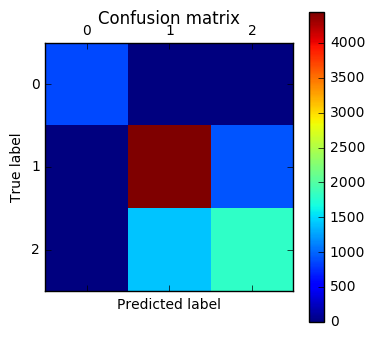

In [150]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

In [151]:
rf.classes_

array(['KICK', 'PASS', 'RUSH'], dtype=object)

In [152]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

In [153]:
gbc.score(X_test, y_test)

0.77771927977255972

[[ 879    0    1]
 [   6 4297 1071]
 [   7 1026 2210]]


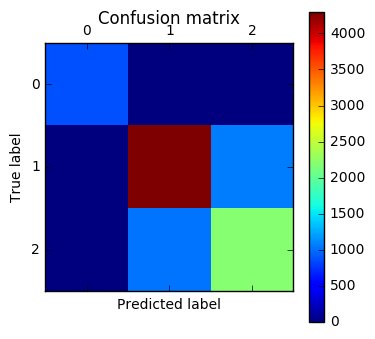

In [154]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

In [155]:
gbc.classes_

array(['KICK', 'PASS', 'RUSH'], dtype=object)

### ===================================

### Combine all seasons together (this can be used as a general "conventional wisdom" model)

In [163]:
df15 = pd.read_csv('../data/pbp2015-clean.csv')
df14 = pd.read_csv('../data/pbp2014-clean.csv')
df13 = pd.read_csv('../data/pbp2013-clean.csv')

In [165]:
print '2015:', df15.shape
print '2014:', df14.shape
print '2013:', df13.shape

2015: (37987, 17)
2014: (37647, 17)
2013: (39490, 17)


In [166]:
df = pd.concat([df15, df14, df13])

In [167]:
df.shape

(115124, 17)

In [168]:
# These have to go for us to build a model, but we will want to use them for user presentation
df.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', 'PassType', 'RushDirection', 'Yards', 'DefenseTeam'], axis=1, inplace=True)

In [169]:
# create dummy variables for formations
form_dummies = pd.get_dummies(df.Formation)
form_dummies.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), form_dummies.columns)

In [170]:
# create dummy variables for teams
team_dummies = pd.get_dummies(df.OffenseTeam)
team_dummies.columns = map(lambda x: 'TEAM_' + str(x), team_dummies.columns)

In [171]:
# combine the dummy variables and drop the categorical versions
df_prepped = pd.concat(
    [df.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'Play']], 
    team_dummies, 
    form_dummies], axis=1)

In [173]:
# split the class from the values
y = df_prepped['Play']
X = df_prepped.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [174]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

In [175]:
gbc.score(X_test, y_test)

0.76289913484590532

[[ 2667     0    12]
 [   11 12502  3463]
 [    2  3336  6788]]


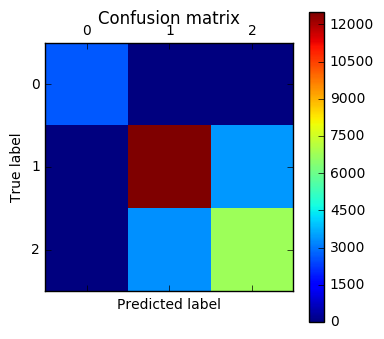

In [176]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

### Try leaving a season/year feature for the model to use

In [179]:
df15['Season'] = 2015
df14['Season'] = 2014
df13['Season'] = 2013

In [298]:
df = pd.concat([df15, df14, df13])

In [299]:
# These have to go for us to build a model, but we will want to use them for user presentation
df.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', 'PassType', 'RushDirection', 'Yards', 'DefenseTeam'], axis=1, inplace=True)

# create dummy variables for formations
form_dummies = pd.get_dummies(df.Formation)
form_dummies.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), form_dummies.columns)

# create dummy variables for teams
team_dummies = pd.get_dummies(df.OffenseTeam)
team_dummies.columns = map(lambda x: 'TEAM_' + str(x), team_dummies.columns)

# combine the dummy variables and drop the categorical versions
df_prepped = pd.concat(
    [df.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'Play']], 
    team_dummies, 
    form_dummies], axis=1)

In [302]:
# split the class from the values
y = df_prepped['Play']
X = df_prepped.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [303]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

In [304]:
gbc.score(X_test, y_test)

0.76289913484590532

[[ 2667     0    12]
 [   11 12502  3463]
 [    2  3336  6788]]


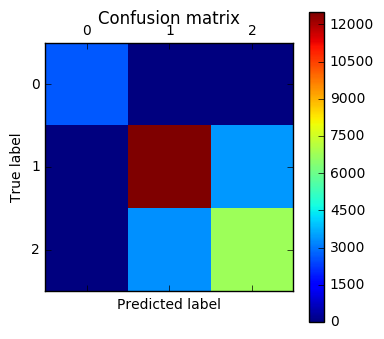

In [305]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

## ==========================================

In [313]:
def prep_record(record):
    
    # Record should be a DataFrame

    formations = [
    'FIELD_GOAL',
    'NO_HUDDLE',
    'NO_HUDDLE_SHOTGUN',
    'PUNT',
    'SHOTGUN',
    'UNDER_CENTER',
    'WILDCAT']  
    
    teams = [
    'ARI', 
    'ATL',
    'BAL',
    'BUF',
    'CAR',
    'CHI',
    'CIN',
    'CLE',
    'DAL',
    'DEN',
    'DET',
    'GB',
    'HOU',
    'IND',
    'JAX',
    'KC',
    'LA',
    'MIA',
    'MIN',
    'NE',
    'NO',
    'NYG',
    'NYJ',
    'OAK',
    'PHI',
    'PIT',
    'SD',
    'SEA',
    'SF',
    'TB',
    'TEN',
    'WAS']

    # Dummy the team
    df2 = pd.get_dummies(record.OffenseTeam)
    dummies_frame = pd.get_dummies(teams)
    df2 = df2.reindex(columns=dummies_frame.columns, fill_value=0)
    df2.columns = map(lambda x: 'TEAM_' + str(x), df2.columns)

    # Dummy the formation
    df1 = pd.get_dummies(record.Formation)
    dummies_frame = pd.get_dummies(formations)
    df1 = df1.reindex(columns=dummies_frame.columns, fill_value=0)
    df1.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), df1.columns)

    # Combine the dummy variables and drop the categorical versions
    record = pd.concat(
        [record.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'Play']],
        df2,
        df1], axis=1)
    
    return record


In [335]:
record = df15.iloc[random.randint(0,df15.shape[0])].copy()

In [336]:
record

Quarter                                                              3
Minute                                                               9
Second                                                              20
OffenseTeam                                                        PHI
DefenseTeam                                                        ATL
Down                                                                 2
ToGo                                                                 6
YardLine                                                             9
Description          (9:20) (NO HUDDLE, SHOTGUN) 7-S.BRADFORD PASS ...
Yards                                                                7
Formation                                            NO HUDDLE SHOTGUN
PlayType                                                          PASS
PassType                                                    SHORT LEFT
RushDirection                                                      NaN
YardLi

In [337]:
record_prepped = prep_record(pd.DataFrame(record).T)

In [338]:
y_one = record_prepped['Play']
X_one = record_prepped.drop(['Play'], axis=1).values

play_pred = gbc.predict(X_one)
print 'Predicted:', play_pred[0]

probas = gbc.predict_proba(X_one)
print '\tKICK: ', '{:04.2f}'.format(probas[0][0])
print '\tPASS: ', '{:04.2f}'.format(probas[0][1])
print '\tRUSH: ', '{:04.2f}'.format(probas[0][2])

if y_one.to_string(index=False) == play_pred[0]:
    print 'Defended!'
else:
    print 'They Scored!'

Predicted: RUSH
	KICK:  0.00
	PASS:  0.35
	RUSH:  0.65
They Scored!


In [341]:
record.Minute

9

In [342]:
type(record_prepped)

pandas.core.frame.DataFrame

In [345]:
record_prepped.to_dict()['Quarter']

{7820: 3}

In [351]:
record

Quarter                                                              3
Minute                                                               9
Second                                                              20
OffenseTeam                                                        PHI
DefenseTeam                                                        ATL
Down                                                                 2
ToGo                                                                 6
YardLine                                                             9
Description          (9:20) (NO HUDDLE, SHOTGUN) 7-S.BRADFORD PASS ...
Yards                                                                7
Formation                                            NO HUDDLE SHOTGUN
PlayType                                                          PASS
PassType                                                    SHORT LEFT
RushDirection                                                      NaN
YardLi

### More exploration

In [13]:
pbp = pd.read_csv('../data/pbp-training.csv')

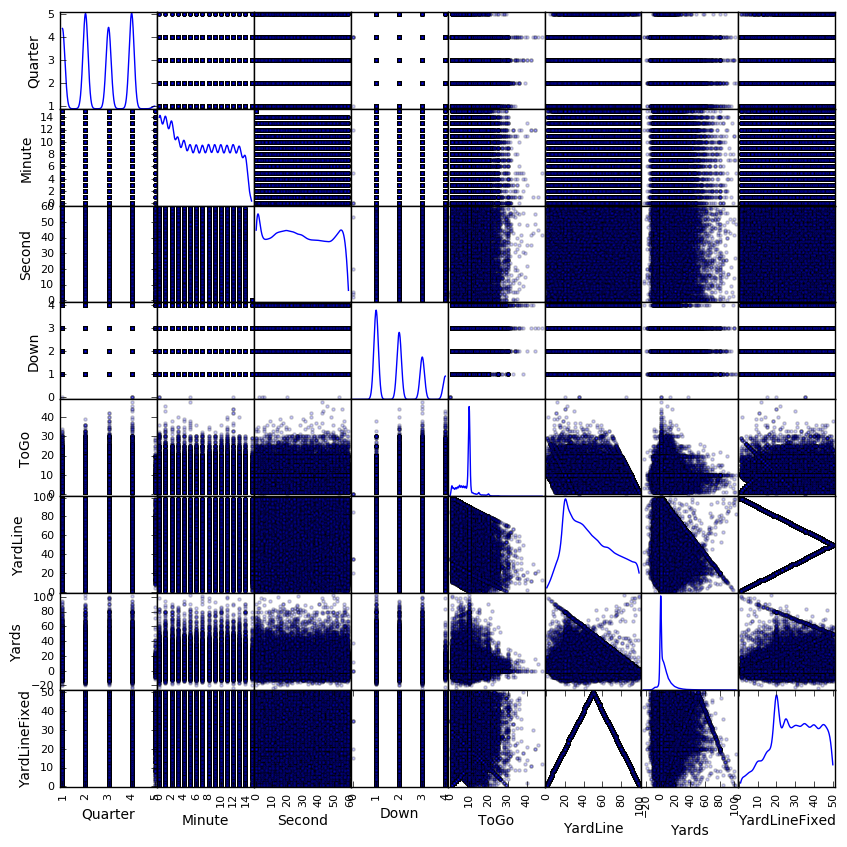

In [36]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(pbp, alpha=0.2, figsize=(10, 10), diagonal='kde');

In [63]:
# Types of plays by team
pd.crosstab(pbp.OffenseTeam, pbp.Play, margins=True).sort_values('All', ascending=False)

Play,KICK,PASS,RUSH,All
OffenseTeam,,,,
All,11455,67678,42365,121498
NE,367,2288,1457,4112
DEN,371,2284,1449,4104
IND,375,2454,1216,4045
SD,346,2235,1447,4028
NO,312,2404,1308,4024
PHI,366,2144,1451,3961
BAL,397,2255,1306,3958
HOU,394,2092,1471,3957


In [64]:
pd.crosstab(pbp.OffenseTeam, pbp.Play).apply(lambda x: x/x.sum(), axis=1)

Play,KICK,PASS,RUSH
OffenseTeam,,,
ARI,0.096757,0.548379,0.354864
ATL,0.083879,0.599476,0.316645
BAL,0.100303,0.569732,0.329965
BUF,0.103730,0.516863,0.379407
CAR,0.094146,0.513449,0.392405
CHI,0.091973,0.565775,0.342252
CIN,0.090008,0.530133,0.379859
CLE,0.099947,0.594115,0.305938
DAL,0.083240,0.533072,0.383688


In [5]:
plays_by_down_and_team = pd.crosstab([pbp.OFFENSETEAM, pbp.DOWN], pbp.PLAY).apply(lambda x: x/x.sum(), axis=1)
plays_by_down_and_team

PLAY                  KICK      PASS      RUSH
OFFENSETEAM DOWN                              
ARI         1     0.003556  0.514936  0.481508
            2     0.000981  0.602552  0.396467
            3     0.003140  0.852433  0.144427
            4     0.927900  0.034483  0.037618
ATL         1     0.003211  0.541426  0.455363
            2     0.000852  0.663543  0.335605
            3     0.004255  0.865248  0.130496
            4     0.831522  0.135870  0.032609
BAL         1     0.002692  0.523553  0.473755
            2     0.003565  0.618538  0.377897
            3     0.007916  0.833773  0.158311
            4     0.851319  0.103118  0.045564
BUF         1     0.000727  0.452364  0.546909
            2     0.002671  0.579697  0.417631
            3     0.001368  0.790698  0.207934
            4     0.896806  0.078624  0.024570
CAR         1     0.002256  0.483459  0.514286
            2     0.003009  0.541625  0.455366
            3     0.006421  0.783307  0.210273
            4     0.895765  0.048860  0.055375
CHI         1     0.000755  0.542296  0.456949
            2     0.005061  0.588057  0.406883
            3     0.006339  0.851030  0.142631
            4     0.847761  0.104478  0.047761
CIN         1     0.000742  0.486647  0.512611
            2     0.000983  0.587021  0.411996
            3     0.000000  0.795527  0.204473
            4     0.855030  0.071006  0.073964
CLE         1     0.003600  0.517639  0.478762
            2     0.003788  0.660038  0.336174
...                    ...       ...       ...
PHI         3     0.004580  0.783206  0.212214
            4     0.892655  0.056497  0.050847
PIT         1     0.000000  0.544598  0.455402
            2     0.005714  0.616190  0.378095
            3     0.003231  0.828756  0.168013
            4     0.885196  0.087613  0.027190
SD          1     0.000674  0.497305  0.502022
            2     0.003630  0.621597  0.374773
            3     0.002967  0.830861  0.166172
            4     0.904762  0.069841  0.025397
SEA         1     0.001447  0.479016  0.519537
            2     0.001947  0.510224  0.487829
            3     0.003190  0.799043  0.197767
            4     0.904025  0.055728  0.040248
SF          1     0.003021  0.493958  0.503021
            2     0.001017  0.585961  0.413021
            3     0.003058  0.799694  0.197248
            4     0.860158  0.092348  0.047493
TB          1     0.001494  0.491412  0.507095
            2     0.000977  0.605469  0.393555
            3     0.003115  0.867601  0.129283
            4     0.858790  0.097983  0.043228
TEN         1     0.001446  0.512654  0.485900
            2     0.000000  0.585034  0.414966
            3     0.001490  0.877794  0.120715
            4     0.873995  0.091153  0.034853
WAS         1     0.002214  0.506273  0.491513
            2     0.003077  0.613333  0.383590
            3     0.001567  0.836991  0.161442
            4     0.855457  0.109145  0.035398

[128 rows x 3 columns]

In [11]:
plt.plot(plays_by_down_and_team)

ValueError: setting an array element with a sequence.

### Find out how important shotgun formation really is

In [17]:
pbp.groupby(['FORMATION','PLAY']).count()

index  GAMEID  GAMEDATE  QUARTER  MINUTE  SECOND  \
FORMATION         PLAY                                                     
FIELD GOAL        KICK   2931    2931      2931     2931    2931    2931   
                  RUSH      1       1         1        1       1       1   
NO HUDDLE         PASS    706     706       706      706     706     706   
                  RUSH   1432    1432      1432     1432    1432    1432   
NO HUDDLE SHOTGUN KICK      3       3         3        3       3       3   
                  PASS   7729    7729      7729     7729    7729    7729   
                  RUSH   2286    2286      2286     2286    2286    2286   
PUNT              KICK   7072    7072      7072     7072    7072    7072   
SHOTGUN           KICK      3       3         3        3       3       3   
                  PASS  39230   39230     39230    39230   39230   39230   
                  RUSH  10029   10029     10029    10029   10029   10029   
UNDER CENTER      KICK     92      92        92       92      92      92   
                  PASS  13330   13330     13330    13330   13330   13330   
                  RUSH  24521   24521     24521    24521   24521   24521   
WILDCAT           RUSH      6       6         6        6       6       6   

                        OFFENSETEAM  DEFENSETEAM   DOWN   TOGO      ...        \
FORMATION         PLAY                                              ...         
FIELD GOAL        KICK         2931         2931   2931   2931      ...         
                  RUSH            1            1      1      1      ...         
NO HUDDLE         PASS          706          706    706    706      ...         
                  RUSH         1432         1432   1432   1432      ...         
NO HUDDLE SHOTGUN KICK            3            3      3      3      ...         
                  PASS         7729         7729   7729   7729      ...         
                  RUSH         2286         2286   2286   2286      ...         
PUNT              KICK         7072         7072   7072   7072      ...         
SHOTGUN           KICK            3            3      3      3      ...         
                  PASS        39230        39230  39230  39230      ...         
                  RUSH        10029        10029  10029  10029      ...         
UNDER CENTER      KICK           92           92     92     92      ...         
                  PASS        13330        13330  13330  13330      ...         
                  RUSH        24521        24521  24521  24521      ...         
WILDCAT           RUSH            6            6      6      6      ...         

                        WEATHER  HOMETEAM  AWAYTEAM  HOMESCORE  AWAYSCORE  \
FORMATION         PLAY                                                      
FIELD GOAL        KICK     2931      2931      2931       2931       2931   
                  RUSH        1         1         1          1          1   
NO HUDDLE         PASS      706       706       706        706        706   
                  RUSH     1432      1432      1432       1432       1432   
NO HUDDLE SHOTGUN KICK        3         3         3          3          3   
                  PASS     7729      7729      7729       7729       7729   
                  RUSH     2286      2286      2286       2286       2286   
PUNT              KICK     7072      7072      7072       7072       7072   
SHOTGUN           KICK        3         3         3          3          3   
                  PASS    39230     39230     39230      39230      39230   
                  RUSH    10029     10029     10029      10029      10029   
UNDER CENTER      KICK       92        92        92         92         92   
                  PASS    13330     13330     13330      13330      13330   
                  RUSH    24521     24521     24521      24521      24521   
WILDCAT           RUSH        6         6         6          6          6   

                        HUMIDITY  TEMPERATU

In [ ]:
# If the offense breaks a huddle and lines up in the shotgun, they throw it 4/5 (80%)of the time.
# There was a fake punt (Saints @ Cowboys wk4 2016), but it wasn't in the training set
# One fake field goal in the training set